# 2016 US Elections Analysis

Importing all the necessary libraries

In [2]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Importing Data

Reading election data file containing the potential attributes across counties which influenced the voting pattern 

In [3]:
election_data = pd.read_csv("US_Election_Data v0.03ma.csv")

Reading State County file containing mapping of state codes to states

In [4]:
State_County = pd.read_csv("State_County_DS.csv")

Removing duplicate state records

In [5]:
State_County_Unique_Records = State_County.groupby(['State','State_Code'],as_index=False).first()

Using Web Scrapping, Collecting Voting Percent of Republic Party and Democratic Party across states and also the total electrol seats won per state

In [6]:
url = ("http://worldpopulationreview.com/states/2016-election-results-by-state/")

In [7]:
page = requests.get(url)

In [8]:
doc = lh.fromstring(page.content)

In [9]:
table_elements = doc.xpath('//tr')

In [10]:
col = []
i=0

In [11]:
for t in table_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

In [12]:
for j in range(1,len(table_elements)):
    T=table_elements[j]
    
    i=0
    
    for t in T.iterchildren():
        data=t.text_content() 
        if i>0:
            try:
                data=int(data)
            except:
                pass
        col[i][1].append(data)
        i+=1

In [13]:
Dict={title:column for (title,column) in col}
seats_won_per_state=pd.DataFrame(Dict)

In [14]:
seats_won_per_state.head()

,State,Votes (D),Vote % (D),Votes (R),Vote % (R),Electoral Votes (D),Electoral Votes (R),2019 Pop.
0,Alabama,"729,547",34.36%,"1,318,255",62.08%,0,9,"4,898,246"
1,Alaska,"116,454",36.55%,"163,387",51.28%,0,3,"735,720"
2,Arizona,"1,161,167",45.13%,"1,252,401",48.67%,0,11,"7,275,070"
3,Arkansas,"380,494",33.65%,"684,872",60.57%,0,6,"3,026,412"
4,California,"8,753,788",61.73%,"4,483,810",31.62%,55,0,"39,747,267"


# Cleaning and Merging Data

Renaming the column names to remove the spaces in the names

In [15]:
seats_won_per_state.columns = ['State','Votes(D)','Vote % (D)','Votes (R)','Vote % (R)','Electoral Votes (D)','Electoral Votes (R)','2019 Pop.']

Merging election data with state county dataset to pull state names 

In [16]:
election_county_state = pd.merge(election_data,State_County_Unique_Records[['State_Code','State']],how = 'left',left_on = 'State',right_on = 'State_Code')

In [17]:
election_county_state.head()

,county,State_x,Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree,Median_Income,Per_votes_Rep,Party_Gov,Voting_Behaviour,State_Code,State_y
0,Autauga County,AL,55221,0.136,93.9,0.335,0.232,51281,0.73,Rep,Rep,AL,Alabama
1,Baldwin County,AL,195121,0.181,95.5,0.288,0.290,50254,0.77,Rep,Rep,AL,Alabama
2,Barbour County,AL,26932,0.161,116.6,0.345,0.125,32964,0.52,Rep,Rep,AL,Alabama
3,Bibb County,AL,22604,0.144,114.6,0.421,0.107,38678,0.77,Rep,Rep,AL,Alabama
4,Blount County,AL,57710,0.166,97.7,0.334,0.129,45813,0.90,Rep,Rep,AL,Alabama


Grouping the election data by states as the further analysis is to be done across states

In [18]:
election_data_per_state = election_county_state.groupby('State_y',as_index = False).agg({'Population_Estimate':['sum'],'Per_Age_over_65':['mean'],'M_per_100_F':['mean'],
                           'Per_high_school_Degree':['mean'],'Per_Bachelor_Degree':['mean'],'Median_Income':['mean'],
                           'Party_Gov':['max']
                          })

In [19]:
election_data_per_state.columns = election_data_per_state.columns.droplevel(1)

Merging election data per state with seats won per state obtained using web scarpping to get vote % across states for various parties

In [20]:
election_analysis_data = pd.merge(election_data_per_state,seats_won_per_state,how = 'left',left_on = 'State_y',right_on = 'State')

Replacing special characters(%) with null for vote % (D) and vote %(R) columns and converting it to float 

In [21]:
election_analysis_data['Vote % (D)'] = election_analysis_data['Vote % (D)'].apply(lambda x: x.replace('%',''))

In [22]:
election_analysis_data['Vote % (D)'] = election_analysis_data['Vote % (D)'].str.strip().astype(float)

In [23]:
election_analysis_data['Vote % (R)'] = election_analysis_data['Vote % (R)'].apply(lambda x: x.replace('%',''))

In [24]:
election_analysis_data['Vote % (R)'] = election_analysis_data['Vote % (R)'].str.strip().astype(float)

# Melting and Reshaping Data

Melting the Electoral Votes(D) and Electoral Votes(R) columns to plot the seat distribution

In [25]:
Votes_per_party = election_analysis_data[['Electoral Votes (D)','Electoral Votes (R)']].melt(value_vars = ['Electoral Votes (D)','Electoral Votes (R)'],
                                                                          var_name = 'Party',value_name = 'Votes')

In [26]:
Votes_per_party.head()

,Party,Votes
0,Electoral Votes (D),0
1,Electoral Votes (D),0
2,Electoral Votes (D),0
3,Electoral Votes (D),0
4,Electoral Votes (D),55


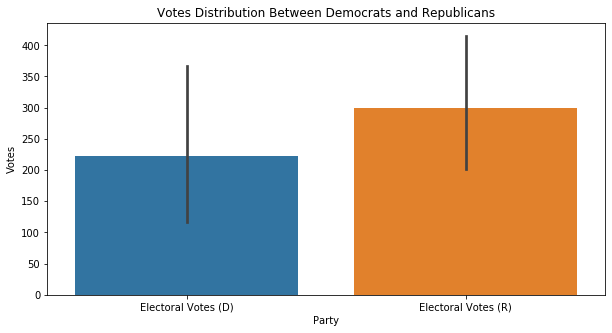

In [27]:
plt.figure(figsize = (10,5))
sns.barplot(x='Party',y='Votes',data= Votes_per_party,estimator = sum);
plt.title("Votes Distribution Between Democrats and Republicans");

It is evident from the above plot that republicans have major share of seats

In [28]:
def voting_behaviour(row):
    if(row['Vote % (D)'] > row['Vote % (R)']):
        return 'Democrats'
    else:
        return 'Republicans'

In [29]:
election_analysis_data['voting_behaviour'] = election_analysis_data.apply(voting_behaviour,axis = 1)

In [42]:
#election_analysis_data.groupby('voting')

In [93]:
np.corrcoef(election_analysis_data['Vote % (R)'],election_analysis_data['Population_Estimate'])

array([[ 1.        , -0.28215102],
       [-0.28215102,  1.        ]])

In [81]:
election_analysis_data.columns

Index(['State_y', 'Population_Estimate', 'Per_Age_over_65', 'M_per_100_F',
       'Per_high_school_Degree', 'Per_Bachelor_Degree', 'Median_Income',
       'Party_Gov', 'State', 'Votes(D)', 'Vote % (D)', 'Votes (R)',
       'Vote % (R)', 'Electoral Votes (D)', 'Electoral Votes (R)',
       '2019 Pop.'],
      dtype='object')

In [78]:
election_analysis_data.head()

,State_y,Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree,Median_Income,Party_Gov,State,Votes(D),Vote % (D),Votes (R),Vote % (R),Electoral Votes (D),Electoral Votes (R),2019 Pop.
0,Alabama,4830620,0.164239,95.050746,0.354627,0.166597,37973.134328,Rep,Alabama,"729,547",34.36,"1,318,255",62.08,0,9,"4,898,246"
1,Alaska,733375,0.095793,120.003448,0.338862,0.215690,64197.103448,Independent,Alaska,"116,454",36.55,"163,387",51.28,0,3,"735,720"
2,Arizona,6641928,0.183267,101.753333,0.288067,0.190333,43252.200000,Rep,Arizona,"1,161,167",45.13,"1,252,401",48.67,0,11,"7,275,070"
3,Arkansas,2958208,0.178920,98.000000,0.394400,0.150240,36626.480000,Rep,Arkansas,"380,494",33.65,"684,872",60.57,0,6,"3,026,412"
4,California,38421464,0.154172,103.572414,0.234879,0.257017,56013.155172,Dem,California,"8,753,788",61.73,"4,483,810",31.62,55,0,"39,747,267"


In [117]:
X = election_analysis_data[['Population_Estimate','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree','Median_Income']]
y = election_analysis_data['Vote % (R)']

In [111]:
X = election_analysis_data[['Population_Estimate']]
y = election_analysis_data['Vote % (R)']

In [119]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state = 8451)

In [120]:
model = LinearRegression(fit_intercept = True)

In [121]:
model.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [122]:
model.score(Xtest,ytest)

0.5637301234256824

In [36]:
merged_df.to_csv("merged_df.csv",index = False)

In [75]:
sns.scatterplot?

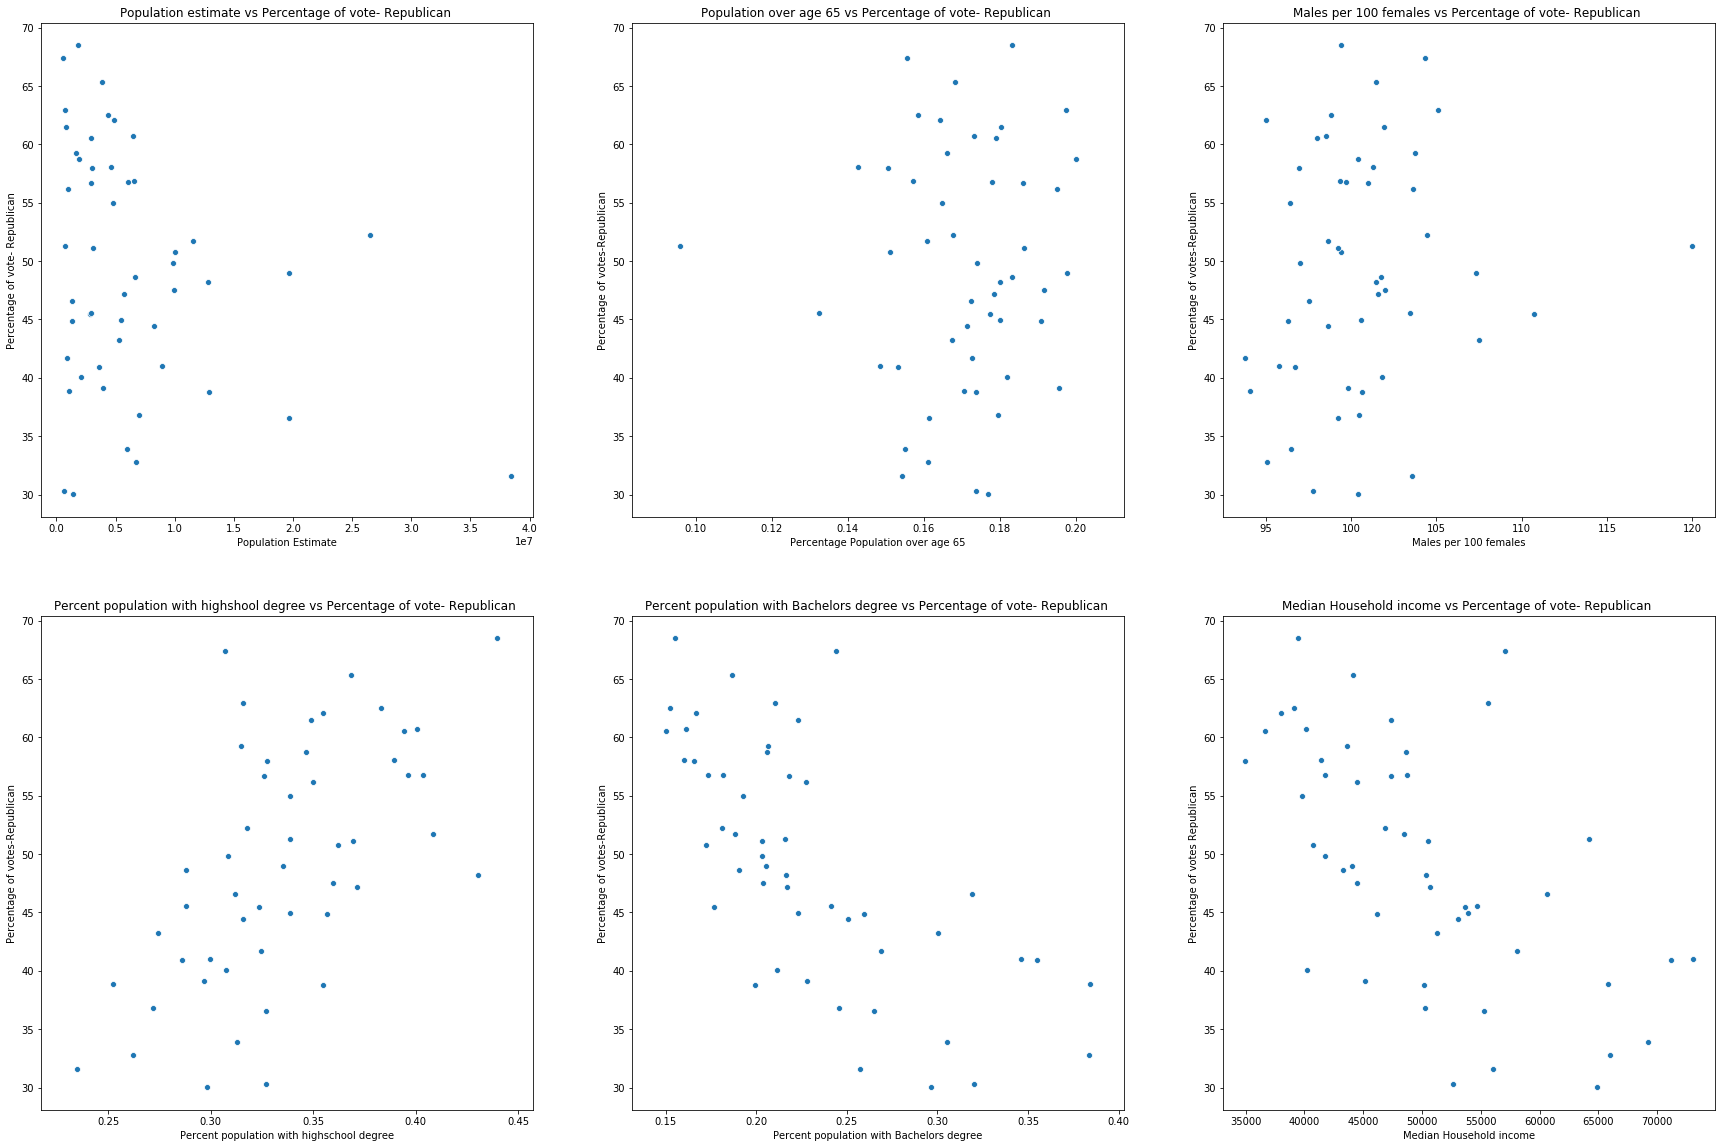

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3 ,figsize=(30,20))
sns.scatterplot(x='Population_Estimate', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,0]);
sns.scatterplot(x='Per_Age_over_65', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,1]);
sns.scatterplot(x='M_per_100_F', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,2]);
sns.scatterplot(x='Per_high_school_Degree', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,0]);
sns.scatterplot(x='Per_Bachelor_Degree', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,1]);
sns.scatterplot(x='Median_Income', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,2]);
ax[0,0].set_xlabel('Population Estimate')
ax[0,0].set_ylabel('Percentage of vote- Republican')
ax[0,0].set_title('Population estimate vs Percentage of vote- Republican ')
ax[0,1].set_xlabel('Percentage Population over age 65')
ax[0,1].set_ylabel('Percentage of votes-Republican')
ax[0,1].set_title('Population over age 65 vs Percentage of vote- Republican ')
ax[0,2].set_xlabel('Males per 100 females')
ax[0,2].set_ylabel('Percentage of votes-Republican')
ax[0,2].set_title('Males per 100 females vs Percentage of vote- Republican ')
ax[1,0].set_xlabel('Percent population with highschool degree')
ax[1,0].set_ylabel('Percentage of votes-Republican')
ax[1,0].set_title('Percent population with highshool degree vs Percentage of vote- Republican ')
ax[1,1].set_xlabel('Percent population with Bachelors degree')
ax[1,1].set_ylabel('Percentage of votes-Republican')
ax[1,1].set_title('Percent population with Bachelors degree vs Percentage of vote- Republican ')
ax[1,2].set_xlabel('Median Household income')
ax[1,2].set_ylabel('Percentage of votes Republican');
ax[1,2].set_title('Median Household income vs Percentage of vote- Republican ');

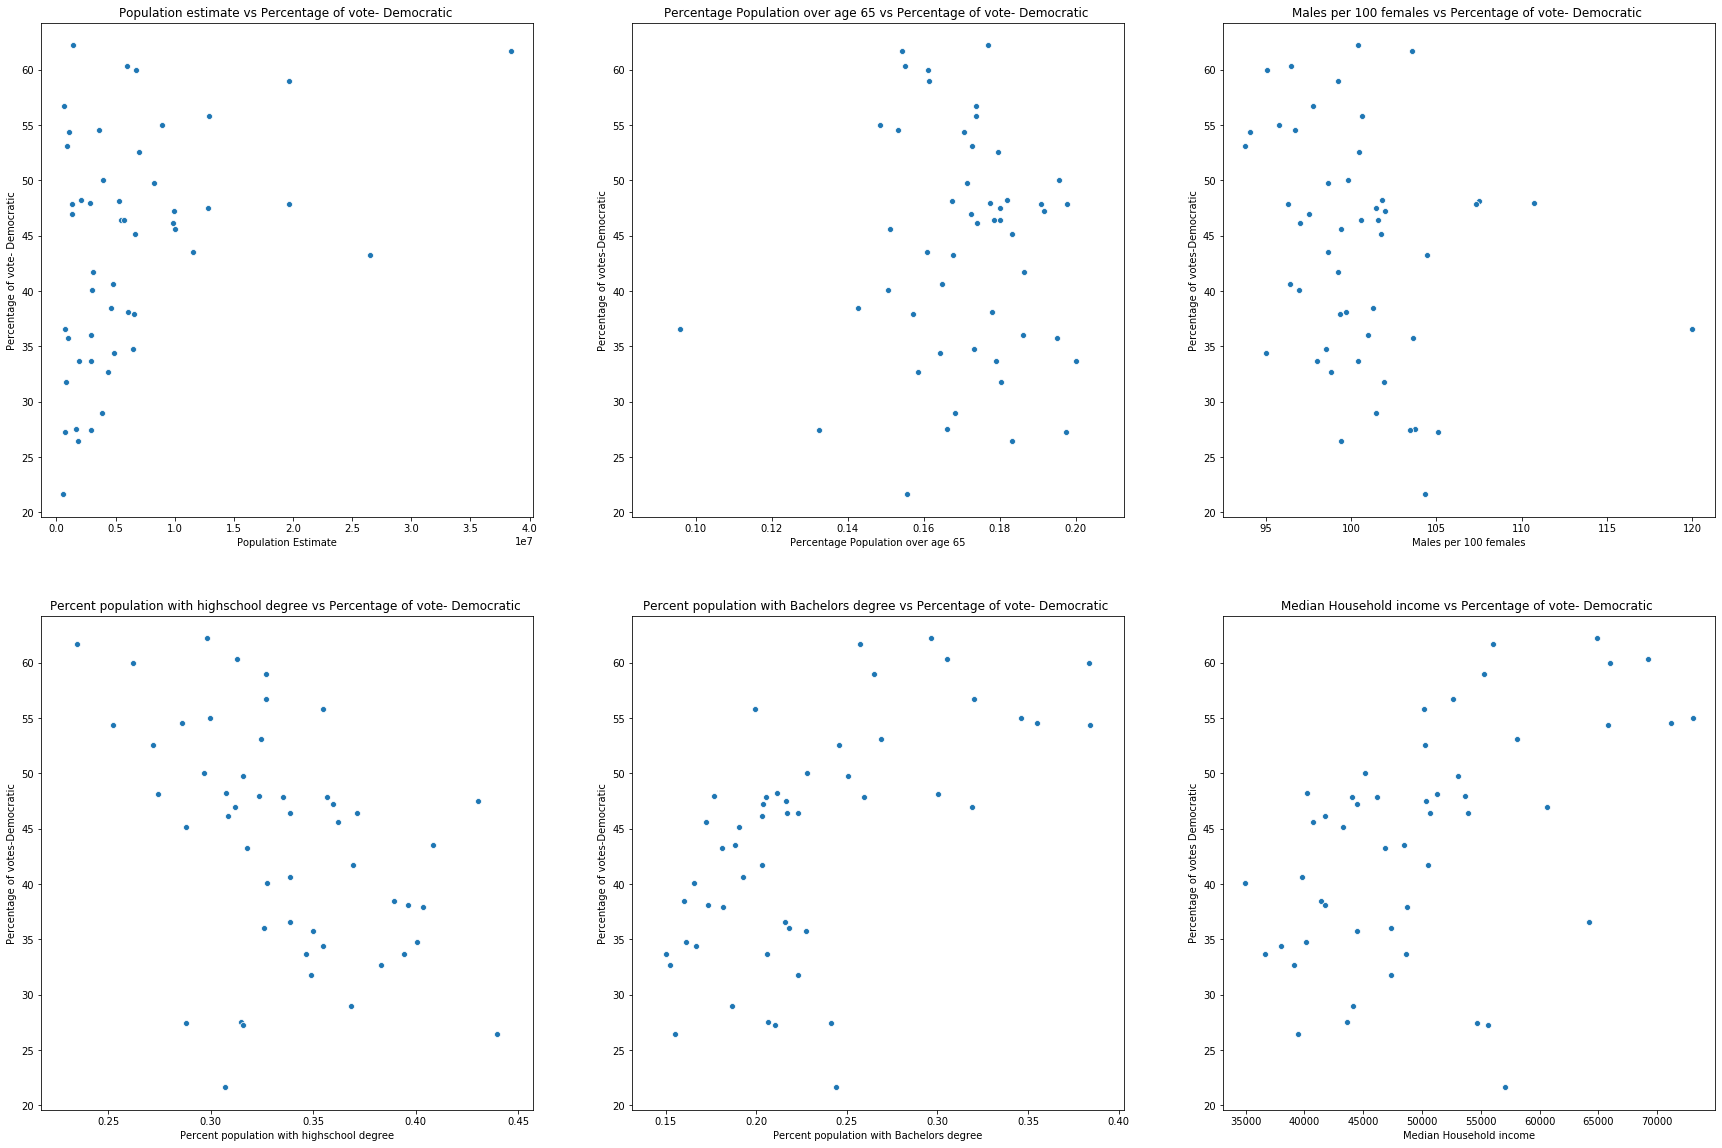

In [48]:
fig, ax = plt.subplots(2,3 ,figsize=(30,20));
sns.scatterplot(x='Population_Estimate', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,0]);
sns.scatterplot(x='Per_Age_over_65', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,1]);
sns.scatterplot(x='M_per_100_F', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,2]);
sns.scatterplot(x='Per_high_school_Degree', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,0]);
sns.scatterplot(x='Per_Bachelor_Degree', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,1]);
sns.scatterplot(x='Median_Income', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,2]);
ax[0,0].set_xlabel('Population Estimate')
ax[0,0].set_ylabel('Percentage of vote- Democratic')
ax[0,1].set_xlabel('Percentage Population over age 65')
ax[0,1].set_ylabel('Percentage of votes-Democratic')
ax[0,2].set_xlabel('Males per 100 females')
ax[0,2].set_ylabel('Percentage of votes-Democratic')
ax[1,0].set_xlabel('Percent population with highschool degree')
ax[1,0].set_ylabel('Percentage of votes-Democratic')
ax[1,1].set_xlabel('Percent population with Bachelors degree')
ax[1,1].set_ylabel('Percentage of votes-Democratic')
ax[1,2].set_xlabel('Median Household income')
ax[1,2].set_ylabel('Percentage of votes Democratic');
ax[0,0].set_title('Population estimate vs Percentage of vote- Democratic ')
ax[0,1].set_title('Percentage Population over age 65 vs Percentage of vote- Democratic ')
ax[0,2].set_title('Males per 100 females vs Percentage of vote- Democratic ')
ax[1,0].set_title('Percent population with highschool degree vs Percentage of vote- Democratic ')
ax[1,1].set_title('Percent population with Bachelors degree vs Percentage of vote- Democratic ')
ax[1,2].set_title('Median Household income vs Percentage of vote- Democratic ');